# Getting Started

In [2]:
# @title Install necessary packages.
!pip install -U dopamine-rl

^C


In [10]:
# @title Necessary imports and globals.

import numpy as np
import os
from dopamine.agents.dqn import dqn_agent
from dopamine.discrete_domains import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags
import gin.tf

BASE_PATH = 'running-data'  # @param
GAME = 'Asterix'  # @param

ModuleNotFoundError: No module named 'flax'

In [5]:
experimental_data = colab_utils.load_baselines('./baselines-data/')

In [6]:
!python -m atari_py.import_roms roms

copying montezuma_revenge.bin from roms/Montezuma's Revenge - Featuring Panama Joe (1984) (Parker Brothers - JWDA, Henry Will IV) (PB5760) ~.bin to /usr/local/lib/python3.7/site-packages/atari_py/atari_roms/montezuma_revenge.bin
copying double_dunk.bin from roms/Double Dunk (Super Basketball) (1989) (Atari, Matthew L. Hubbard) (CX26159) ~.bin to /usr/local/lib/python3.7/site-packages/atari_py/atari_roms/double_dunk.bin
copying pacman.bin from roms/Pac-Man (1982) (Atari, Tod Frye) (CX2646) (PAL).bin to /usr/local/lib/python3.7/site-packages/atari_py/atari_roms/pacman.bin
copying atlantis.bin from roms/Atlantis (Lost City of Atlantis) (1982) (Imagic, Dennis Koble) (720103-1A, 720103-1B, IA3203, IX-010-04) ~.bin to /usr/local/lib/python3.7/site-packages/atari_py/atari_roms/atlantis.bin
copying ms_pacman.bin from roms/Ms. Pac-Man (1983) (Atari - GCC, Mark Ackerman, Glenn Parker) (CX2675) ~.bin to /usr/local/lib/python3.7/site-packages/atari_py/atari_roms/ms_pacman.bin
copying defender.bin 

# DQN Prioritized

In [12]:
LOG_PATH = os.path.join(BASE_PATH, 'prioritized_dqn', GAME)

In [13]:
# @title Create the DQN with prioritized replay
from dopamine.replay_memory import prioritized_replay_buffer
import tensorflow as tf

class PrioritizedDQNAgent(dqn_agent.DQNAgent):
  def __init__(self, sess, num_actions):
    """This maintains all the DQN default argument values."""
    super().__init__(sess, num_actions)
    self._replay_scheme = 'prioritized'

  def _build_replay_buffer(self, use_staging):
    return prioritized_replay_buffer.WrappedPrioritizedReplayBuffer(
        observation_shape=self.observation_shape,
        stack_size=self.stack_size,
        use_staging=use_staging,
        update_horizon=self.update_horizon,
        gamma=self.gamma,
        observation_dtype=self.observation_dtype.as_numpy_dtype)

  def _build_train_op(self):
    """Builds a training op.
    Returns:
      train_op: An op performing one step of training from replay data.
    """
    replay_action_one_hot = tf.one_hot(
        self._replay.actions, self.num_actions, 1., 0., name='action_one_hot')
    replay_chosen_q = tf.reduce_sum(
        self._replay_net_outputs.q_values * replay_action_one_hot,
        axis=1,
        name='replay_chosen_q')

    target = tf.stop_gradient(self._build_target_q_op())
    loss = tf.compat.v1.losses.huber_loss(
        target, replay_chosen_q, reduction=tf.losses.Reduction.NONE)
    # The original prioritized experience replay uses a linear exponent
    # schedule 0.4 -> 1.0. Comparing the schedule to a fixed exponent of 0.5
    # on 5 games (Asterix, Pong, Q*Bert, Seaquest, Space Invaders) suggested
    # a fixed exponent actually performs better, except on Pong.
    probs = self._replay.transition['sampling_probabilities']
    loss_weights = 1.0 / tf.sqrt(probs + 1e-10)
    loss_weights /= tf.reduce_max(loss_weights)

    # Rainbow and prioritized replay are parametrized by an exponent alpha,
    # but in both cases it is set to 0.5 - for simplicity's sake we leave it
    # as is here, using the more direct tf.sqrt(). Taking the square root
    # "makes sense", as we are dealing with a squared loss.
    # Add a small nonzero value to the loss to avoid 0 priority items. While
    # technically this may be okay, setting all items to 0 priority will cause
    # troubles, and also result in 1.0 / 0.0 = NaN correction terms.
    update_priorities_op = self._replay.tf_set_priority(
        self._replay.indices, tf.sqrt(loss + 1e-10))

    # Weight the loss by the inverse priorities.
    loss = loss_weights * loss
    
    with tf.control_dependencies([update_priorities_op]):
      if self.summary_writer is not None:
        with tf.compat.v1.variable_scope('Losses'):
          tf.compat.v1.summary.scalar('HuberLoss', tf.reduce_mean(loss))
      return self.optimizer.minimize(tf.reduce_mean(loss))

  def _store_transition(self,
                        last_observation,
                        action,
                        reward,
                        is_terminal,
                        priority=None):
    priority = self._replay.memory.sum_tree.max_recorded_priority
    if not self.eval_mode:
      self._replay.add(last_observation, action, reward, is_terminal, priority)
def create_prioritized_dqn_agent(sess, environment, summary_writer=None):
  """The Runner class will expect a function of this type to create an agent."""
  return PrioritizedDQNAgent(sess, num_actions=environment.action_space.n)

prioritized_dqn_config = """
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
import dopamine.agents.dqn.dqn_agent
import dopamine.replay_memory.prioritized_replay_buffer
import gin.tf.external_configurables

DQNAgent.gamma = 0.99
DQNAgent.update_horizon = 1
DQNAgent.min_replay_history = 20000  # agent steps
DQNAgent.update_period = 4
DQNAgent.target_update_period = 8000  # agent steps
DQNAgent.epsilon_train = 0.01
DQNAgent.epsilon_eval = 0.001
DQNAgent.epsilon_decay_period = 250000  # agent steps
DQNAgent.tf_device = '/gpu:0'  # use '/cpu:*' for non-GPU version
DQNAgent.optimizer = @tf.train.RMSPropOptimizer()

tf.train.RMSPropOptimizer.learning_rate = 0.00025
tf.train.RMSPropOptimizer.decay = 0.95
tf.train.RMSPropOptimizer.momentum = 0.0
tf.train.RMSPropOptimizer.epsilon = 0.00001
tf.train.RMSPropOptimizer.centered = True

atari_lib.create_atari_environment.game_name = '{}'
# Sticky actions with probability 0.25, as suggested by (Machado et al., 2017).
atari_lib.create_atari_environment.sticky_actions = True
create_agent.agent_name = 'dqn'
Runner.num_iterations = 200
Runner.training_steps = 250000  # agent steps
Runner.evaluation_steps = 125000  # agent steps
Runner.max_steps_per_episode = 27000  # agent steps

WrappedPrioritizedReplayBuffer.replay_capacity = 1000000
WrappedPrioritizedReplayBuffer.batch_size = 32
""".format(GAME)
gin.parse_config(prioritized_dqn_config, skip_unknown=False)

# Create the runner class with this agent. We use very small numbers of steps
# to terminate quickly, as this is mostly meant for demonstrating how one can
# use the framework.
prioritized_dqn_runner = run_experiment.TrainRunner(LOG_PATH, create_prioritized_dqn_agent)

In [ ]:
# @title Train MyRandomDQNAgent.
print('Will train agent, please be patient, may be a while...')
prioritized_dqn_runner.run_experiment()
print('Done training!')

Will train agent, please be patient, may be a while...
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


In [ ]:
# @title Load the training logs.
prioritized_dqn_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
prioritized_dqn_data['agent'] = 'DQN Prioritized'
prioritized_dqn_data['run_number'] = 1
experimental_data[GAME] = experimental_data[GAME].merge(prioritized_dqn_data, how='outer')

Reading statistics from: running-data/prioritized_dqn/Asterix//logs/log_59


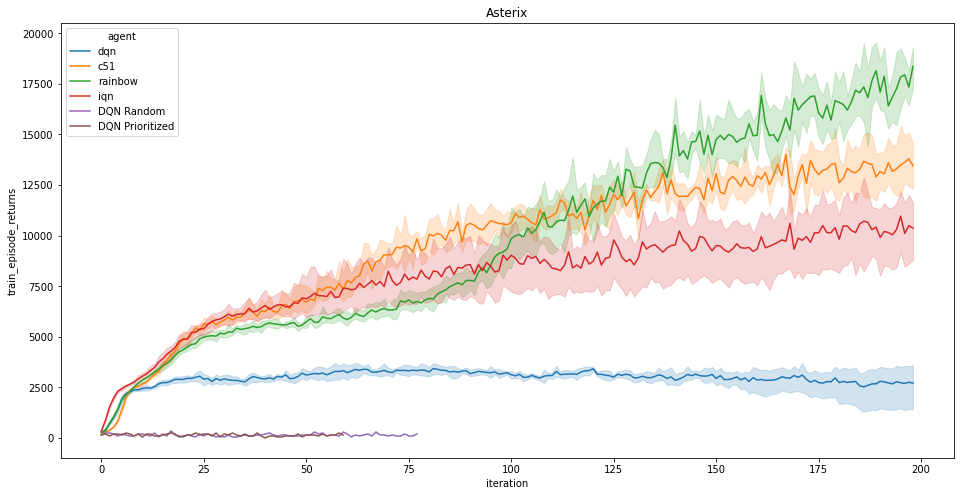

In [ ]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(
    x='iteration', y='train_episode_returns', hue='agent',
    data=experimental_data[GAME], ax=ax)
plt.title(GAME)
plt.show()

# DQN Plain

In [11]:
LOG_PATH = os.path.join(BASE_PATH, 'plain_dqn', GAME)

In [ ]:
# @title Create the DQN with Plain setup
from dopamine.replay_memory import prioritized_replay_buffer
import tensorflow as tf

def create_plain_dqn_agent(sess, environment, summary_writer=None):
  """The Runner class will expect a function of this type to create an agent."""
  return dqn_agent.DQNAgent(sess, num_actions=environment.action_space.n)

plain_dqn_config = """
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
import dopamine.agents.dqn.dqn_agent
import dopamine.replay_memory.circular_replay_buffer
import gin.tf.external_configurables

DQNAgent.gamma = 0.99
DQNAgent.update_horizon = 1
DQNAgent.min_replay_history = 20000  # agent steps
DQNAgent.update_period = 4
DQNAgent.target_update_period = 8000  # agent steps
DQNAgent.epsilon_train = 0.01
DQNAgent.epsilon_eval = 0.001
DQNAgent.epsilon_decay_period = 250000  # agent steps
DQNAgent.tf_device = '/gpu:0'  # use '/cpu:*' for non-GPU version
DQNAgent.optimizer = @tf.train.RMSPropOptimizer()

tf.train.RMSPropOptimizer.learning_rate = 0.00025
tf.train.RMSPropOptimizer.decay = 0.95
tf.train.RMSPropOptimizer.momentum = 0.0
tf.train.RMSPropOptimizer.epsilon = 0.00001
tf.train.RMSPropOptimizer.centered = True

atari_lib.create_atari_environment.game_name = '{}'
# Sticky actions with probability 0.25, as suggested by (Machado et al., 2017).
atari_lib.create_atari_environment.sticky_actions = True
create_agent.agent_name = 'dqn'
Runner.num_iterations = 200
Runner.training_steps = 250000  # agent steps
Runner.evaluation_steps = 125000  # agent steps
Runner.max_steps_per_episode = 27000  # agent steps

WrappedReplayBuffer.replay_capacity = 1000000
WrappedReplayBuffer.batch_size = 32
""".format(GAME)
gin.parse_config(plain_dqn_config, skip_unknown=False)

# Create the runner class with this agent. We use very small numbers of steps
# to terminate quickly, as this is mostly meant for demonstrating how one can
# use the framework.
plain_dqn_runner = run_experiment.TrainRunner(LOG_PATH, create_plain_dqn_agent)

In [ ]:
# @title Train MyRandomDQNAgent.
print('Will train agent, please be patient, may be a while...')
plain_dqn_runner.run_experiment()
print('Done training!')

In [7]:
# @title Load the training logs.
plain_dqn_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
plain_dqn_data['agent'] = 'DQN Plain'
plain_dqn_data['run_number'] = 1
experimental_data[GAME] = experimental_data[GAME].merge(plain_dqn_data, how='outer')

Reading statistics from: running-data/plain_dqn/Asterix//logs/log_6


In [8]:
!pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


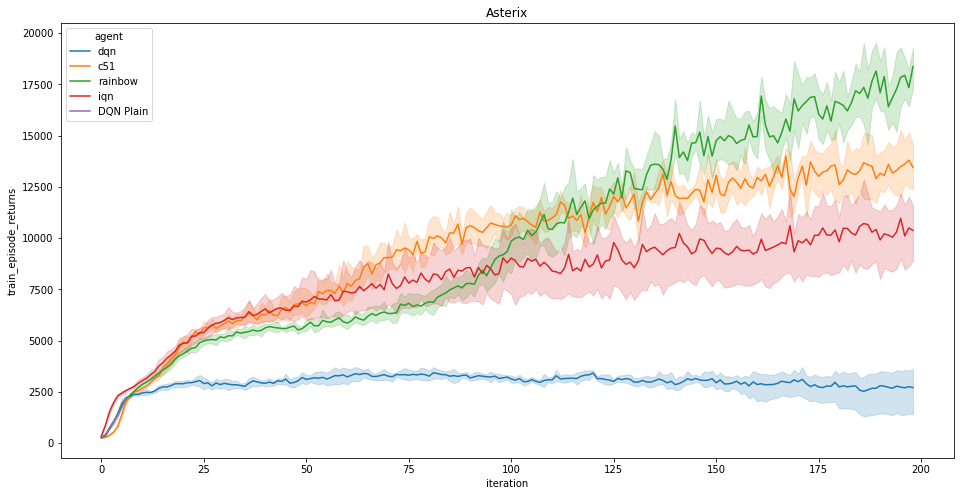

In [9]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(
    x='iteration', y='train_episode_returns', hue='agent',
    data=experimental_data[GAME], ax=ax)
plt.title(GAME)
plt.show()

# Upload to git



1.   manually clone the repo to local computer
2.   download this file and overwrite into the repo
3.   resolve conflicts, push to origin



# Try out stable-baselines

In [1]:
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3 import A2C, DQN

# There already exists an environment generator
# that will make and wrap atari environments correctly.
# Here we are also multi-worker training (n_envs=4 => 4 environments)
env = make_atari_env('PongNoFrameskip-v4', n_envs=1, seed=0)

model = DQN('CnnPolicy', env, verbose=1, device='cuda')
model.learn(total_timesteps=25000000)

obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()

C:\Users\apple\anaconda3\envs\dopamine-need\lib\site-packages\setuptools\distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


Using cpu device
Wrapping the env in a VecTransposeImage.


C:\Users\apple\anaconda3\envs\dopamine-need\lib\site-packages\stable_baselines3\common\buffers.py:200: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 9.13GB
  "This system does not have apparently enough memory to store the complete "


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.6e+03  |
|    ep_rew_mean      | -20.2    |
|    exploration rate | 0.999    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 241      |
|    time_elapsed     | 14       |
|    total timesteps  | 3580     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.54e+03 |
|    ep_rew_mean      | -20.4    |
|    exploration rate | 0.997    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 243      |
|    time_elapsed     | 28       |
|    total timesteps  | 7024     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.54e+03 |
|    ep_rew_mean      | -20.5    |
|    exploration rate | 0.996    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72e+03 |
|    ep_rew_mean      | -20.3    |
|    exploration rate | 0.97     |
| time/               |          |
|    episodes         | 84       |
|    fps              | 100      |
|    time_elapsed     | 771      |
|    total timesteps  | 77636    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000268 |
|    n_updates        | 6908     |
----------------------------------


KeyboardInterrupt: 

In [28]:
env.close()